In [ ]:
%matplotlib inline
from fastai import *
from fastai.vision import *

## MNIST CNN

### Data

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
path.ls()

[PosixPath('/home/jhoward/.fastai/data/mnist_png/training'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/models'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/testing')]

In [ ]:
il = ImageItemList.from_folder(path, convert_mode='L')

In [ ]:
il.items[0]

PosixPath('/home/jhoward/.fastai/data/mnist_png/training/8/56315.png')

In [ ]:
defaults.cmap='binary'

In [ ]:
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jhoward/.fastai/data/mnist_png

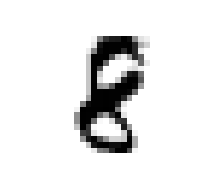

In [ ]:
il[0].show()

In [ ]:
sd = il.split_by_folder(train='training', valid='testing')

In [ ]:
sd

ItemLists;
Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jhoward/.fastai/data/mnist_png;
Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jhoward/.fastai/data/mnist_png;
Test: None

In [ ]:
(path/'training').ls()

[PosixPath('/home/jhoward/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/jhoward/.fastai/data/mnist_png/training/0')]

In [ ]:
ll = sd.label_from_folder()

In [ ]:
ll

LabelLists;
Train: LabelList
y: CategoryList (60000 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: /home/jhoward/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jhoward/.fastai/data/mnist_png;
Valid: LabelList
y: CategoryList (10000 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: /home/jhoward/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jhoward/.fastai/data/mnist_png;
Test: None

In [ ]:
x,y = ll.train[0]

8 torch.Size([1, 28, 28])


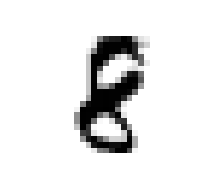

In [ ]:
x.show()
print(y,x.shape)

In [ ]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [ ]:
ll = ll.transform(tfms)

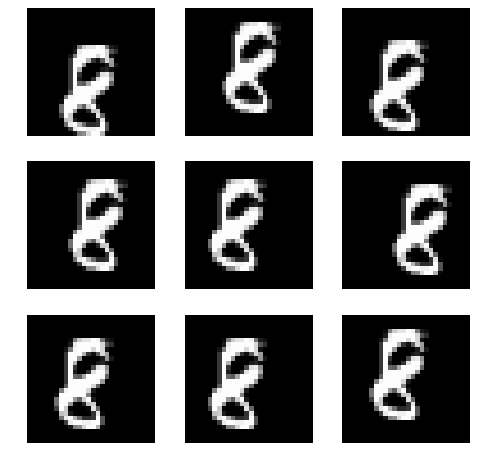

In [ ]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [ ]:
bs = 128

In [ ]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [ ]:
x,y = data.train_ds[0]

8


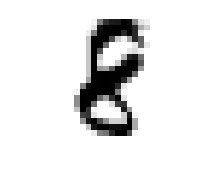

In [ ]:
x.show()
print(y)

In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

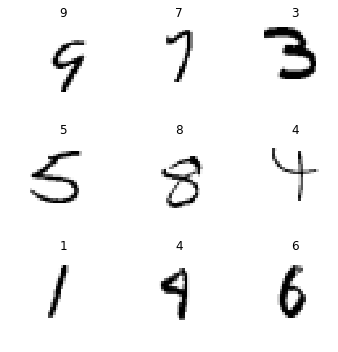

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [ ]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [ ]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.summary()

Layer (type)               Output Shape         Param #   
Conv2d                    [128, 8, 14, 14]     80                  
________________________________________________________________________________
BatchNorm2d               [128, 8, 14, 14]     16                  
________________________________________________________________________________
ReLU                      [128, 8, 14, 14]     0                   
________________________________________________________________________________
Conv2d                    [128, 16, 7, 7]      1168                
________________________________________________________________________________
BatchNorm2d               [128, 16, 7, 7]      32                  
________________________________________________________________________________
ReLU                      [128, 16, 7, 7]      0                   
________________________________________________________________________________
Conv2d                    [128, 32, 4, 4]      

In [ ]:
xb = xb.cuda()

In [ ]:
model(xb).shape

torch.Size([128, 10])

In [ ]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


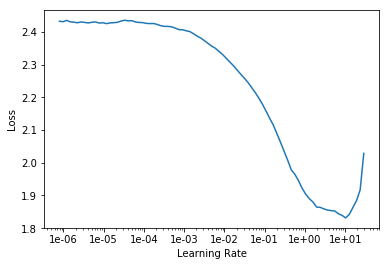

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.215413,0.169024,0.945300
2,0.129223,0.080600,0.974500
3,0.071847,0.042908,0.986400


### Refactor

In [ ]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [ ]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.222127,0.147457,0.955700
2,0.189791,0.305912,0.895600
3,0.167649,0.098644,0.969200
4,0.134699,0.110108,0.961800
5,0.119567,0.139970,0.955700
6,0.104864,0.070549,0.978500
7,0.082227,0.064342,0.979300
8,0.060774,0.055740,0.983600
9,0.054005,0.029653,0.990900
10,0.050926,0.028379,0.991100


### Resnet-ish

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [ ]:
def res_block(nf): return SequentialResBlock(conv_layer(nf,nf), conv_layer(nf,nf, bn_zero=True))

In [ ]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [ ]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [ ]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


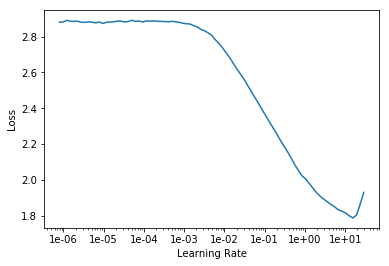

In [ ]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.179228,0.102691,0.971300
2,0.111155,0.089420,0.973400
3,0.099729,0.053458,0.982500
4,0.085445,0.160019,0.951700
5,0.074078,0.063749,0.980800
6,0.057730,0.090142,0.973800
7,0.054202,0.034091,0.989200
8,0.043408,0.042037,0.986000
9,0.033529,0.023126,0.992800
10,0.023253,0.017727,0.994400


## fin